# Cole Win Above Replacement Value (CWARP) Jupyter Notebook Tutorial

COLE WINS ABOVE REPLACEMENT PORTFOLIO (CWARP)™ is a new metric devised by Artemis Capital Management that accurately measures whether a new investment improves the returns and risk of your total Portfolio. The metric evaluates the non-linearity and correlation benefits of alternative investments where Sharpe Ratios and other ratios fail. CWARP is quick to calculate while providing a practical assessment of how an investment contributes to portfolio success. 

CWARP is "wins over replacement " for the asset management industry. It is a one-stop-number that assesses whether alternate investments improve or hurt the pre-existing Portfolio, measuring return, risk, and maximum drawdown altogether. A positive CWARP investment increases the Sortino Ratio of your Portfolio, decreases Maximum Drawdowns, or both. CWARP eliminates investments that "pad" performance statistics with leveraged beta and concave returns. CWARP helps fiduciaries identify hidden gems, true diversifying investments and managers that help the return to risk of your Portfolio. 

The following workbook provides step-by-step examples and code to replicate the CWARP ratio for portfolios. Yahoo Finance API is used to provide stock data and create efficient frontier. 
www.artemiscm.com

In [1]:
import pandas as pd 
import numpy as np
from datetime import date

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import yfinance as yf
yf.pdr_override()
import pandas as pd

C:\Users\Christopher Cole\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Traditional Risk to Return Portfolio Metrics
To calculate the CWARP ratio first we must provide functions for classic risk-reward metrics like the Sharpe Ratio, Sortino Ratio, and Maximum Drawdown

In [2]:
#Risk and Reward Functions##################################################################
def sharpe_ratio(df,risk_free=0,periodicity=252):
    risk_free=(1+risk_free)**(1/periodicity)-1
    dfMean=np.mean(df)-risk_free
    dfSTD=np.std(df)
    dfSharpe=dfMean/dfSTD*np.sqrt(periodicity)
    return dfSharpe

def sortino_ratio(df,risk_free=0,periodicity=252):
    neg_ndx = np.where(df<0)[0]
    dfSTD= np.std(df[neg_ndx])
    risk_free=(1+risk_free)**(1/periodicity)-1
    dfMean=np.mean(df)-risk_free
    dfSortino=(dfMean/dfSTD)*np.sqrt(periodicity)
    return dfSortino

def return_maxdd_ratio(df,risk_free=0,periodicity=252):
    #drop zero means you will drop all zero values from the calculation
    risk_free=(1+risk_free)**(1/periodicity)-1
    dfMean=(1+np.mean(df)-risk_free)**(periodicity)-1
    maxDD=max_dd(df,use_window=False,window=252,return_data=False)
    return dfMean/abs(maxDD)

def annualized_return(returns,periodicity=252):
    """Assumes returns is a pandas Series"""
    #start_date=returns.index[0]
    #end_date=returns.index[-1]
    #difference_in_years = (end_date-start_date).days/days_in_year
    difference_in_years = len(returns)/periodicity
    r = np.cumprod(returns+1.)
    start_NAV=1
    end_NAV=r[-1]
    AnnualReturn = (1 + (end_NAV - 1) / 1)** (1 / difference_in_years) - 1
    return AnnualReturn

def avg_positive(ret,dropzero=1):
    if dropzero>0:
        positives = ret > 0
    else:
        positives = ret >= 0
    if positives.any():
        return np.mean(ret[positives])
    else:
        return 0.000000000000000000000000000001

def avg_neg(ret):
    negatives = ret < 0
    if negatives.any():
        return np.mean(ret[negatives])
    else:
        return -1*0.000000000000000000000000000001

def win_pct(ret,dropzero=1):
    if dropzero>0:
        win=len(np.where(ret>0)[0])
        total=len(ret)
    else:
        win=len(np.where(ret>=0)[0])
        total=len(ret)
    return (win/total)

def max_dd(pct_df,use_window=False,window=252,return_data=False):
    #calculates the maximum drawdown for the strategy cumulatively or over a rolling window period
    #use_window initiates rolling period, otherwise is cumulative
    #return data provides the raw datastream rather than the min
    if use_window==False:
        out=((((pct_df + 1).cumprod()-(pct_df + 1).cumprod().cummax())/(pct_df + 1).cumprod().cummax()).dropna())
    else:
        out=(((pct_df + 1).cumprod()-(pct_df + 1).cumprod().rolling(window).max())/(pct_df + 1).cumprod().rolling(window).max()).dropna()
    if return_data==True:
        out = out
    else:
        out = min(out)
    return out

def kelly(df,dropzero=0):
    if dropzero==1: df = df[(df!= 0)]
    avg_pos=df[df>=0].mean()
    avg_neg=df[df<0].mean()
    win_pct=df[df>=0].count()/df.count()
    loss_pct=(1-win_pct)
    return ((avg_pos/abs(avg_neg))*win_pct-(loss_pct))/(avg_pos/abs(loss_pct))

def return_analyz(df_pct,bck_test_name='BackTest',bop=None,eop=None):
    df_pct=df_pct.copy()
    if bop==None: bop=min(df_pct.index)
    if eop==None: eop=max(df_pct.index)    
        
    sharpe=SharpeAdj(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)].to_numpy(),dropzero=1, periodicity=252)
    sortino=SortinoAdj(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)].to_numpy(),dropzero=1, periodicity=252)
    annret=annualized_return(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)].to_numpy(),periodicity=252)
    maxdd=max_dd(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)],use_window=False,return_data=False)
    calmar=annret/abs(maxdd)
    #calmar=annualized_return(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)].to_numpy(),days_in_year=252)/abs(max_dd(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)]))
    vol=np.std(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)])*((252)**.5)
    worst_day=min(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)])
    best_day=min(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)])
    win_pct=df_pct[df_pct>=0].count()/df_pct.count()
    avg_positive=df_pct[df_pct>=0].mean()
    avg_neg=df_pct[df_pct<0].mean()
    kelly1=kelly(df_pct[(df_pct.index>=bop)&(df_pct.index<=eop)],dropzero=0)
    data=[annret,vol,sharpe,sortino,maxdd,calmar,kelly,bop,eop]
    arr= pd.DataFrame({'AnnRet': annret, 'Vol': vol, 'Sharpe': sharpe, 'Sortino': sortino, 'MaxDD': maxdd, 'Calmar': calmar,
                       'Kelly': kelly1, 'bop': bop, 'eop': eop},index=[bck_test_name])
    return arr

def monthly_ret_matrix(daily_nav_df):
    return_df=daily_nav_df.iloc[:,0]
    return_df=pd.DataFrame(return_df.resample('M').last())
    return_df['Monthly%']=return_df.pct_change()
    return_df['month']=pd.DatetimeIndex(return_df.index).month
    return_df['year']=pd.DatetimeIndex(return_df.index).year
    return_table=pd.pivot_table(return_df,index=["month"],
                   values=["Monthly%"],
                   aggfunc='sum',fill_value=None,
                   columns=["year"])
    return_table=return_table.append(pd.DataFrame(((return_table+1).cumprod()-1).iloc[-1,:]).rename(columns={12: "Annual"}).T)
    return return_table

def ReturnTable(daily_nav_df,freq='1M'):
    return_df=daily_pct_df.resample('1M').last()
    return_df

# Cole Win Above Replacement Portfolio:

COLE WINS ABOVE REPLACEMENT PORTFOLIO (CWARP)™ is a new metric devised by Artemis Capital Management that accurately measures whether a new investment improves the returns and risk of your total Portfolio. The metric evaluates the non-linearity and correlation benefits of alternative investments where Sharpe Ratios and other ratios fail. CWARP is quick to calculate while providing a practical assessment of how an investment contributes to portfolio success. 

In [3]:

def cole_win_above_replace_port(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    # Cole Win Above Replacement Portolio: Calculate additive return to unit of risk for a new asset on an existing portfolio
    # new_asset = returns of the asset you are thinking of adding to your portfolio
    # replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    # risk_free_rate = Tbill rate 
    # financing_rate = portfolio margin/borrowing cost to layer new asset on top of prevailing portfolio
    # weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    # weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    # periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count

    risk_free_rate=(1+risk_free_rate)**(1/periodicity)-1
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    replace_port_ex_rf=replace_port-risk_free_rate
    new_port_returns_ex_rf=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)-risk_free_rate
    new_port=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)

    #Calculate Replacement Portfolio Sortino Ratio
    neg_ndx = np.where(replace_port<0)[0]
    replace_port_sortino=np.mean(replace_port_ex_rf)/(np.std(replace_port[neg_ndx]))*np.sqrt(periodicity)

    #Calculate Replacement Portfolio Return to Max Drawdown
    maxdd_replace_port=min((((replace_port + 1).cumprod()-(replace_port + 1).cumprod().cummax())/(replace_port + 1).cumprod().cummax()).dropna())
    replace_port_return_maxdd= ((1+np.mean(replace_port_ex_rf))**(periodicity)-1)/abs(maxdd_replace_port)

    #Calculate New Portfolio Sortino Ratio
    neg_ndx_new = np.where(new_port<0)[0]
    new_port_sortino=np.mean(new_port_returns_ex_rf)/(np.std(new_port[neg_ndx_new]))*np.sqrt(periodicity)

    #Calculate New Portfolio Return to Max Drawdown
    maxdd_new_port=min((((new_port + 1).cumprod()-(new_port + 1).cumprod().cummax())/(new_port + 1).cumprod().cummax()).dropna())
    new_port_return_maxdd= ((1+np.mean(new_port_returns_ex_rf))**(periodicity)-1)/abs(maxdd_new_port)

    #Final CWARP calculation
    CWARP=(((new_port_return_maxdd/replace_port_return_maxdd)*(new_port_sortino/replace_port_sortino))**(1/2)-1)*100


    return CWARP

def cwarp_additive_sortino(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    # new_asset = returns of the asset you are thinking of adding to your portfolio
    # replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    # risk_free_rate = Tbill rate 
    # financing_rate = portfolio margin/borrowing cost to layer new asset on top of prevailing portfolio
    # weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    # weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    # periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count

    risk_free_rate=(1+risk_free_rate)**(1/periodicity)-1
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    replace_port_ex_rf=replace_port-risk_free_rate
    new_port_returns_ex_rf=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)-risk_free_rate
    new_port=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)

    #Calculate Replacement Portfolio Sortino Ratio
    neg_ndx = np.where(replace_port<0)[0]
    replace_port_sortino=np.mean(replace_port_ex_rf)/(np.std(replace_port[neg_ndx]))*np.sqrt(periodicity)

    #Calculate Replacement Portfolio Return to Max Drawdown
    maxdd_replace_port=min((((replace_port + 1).cumprod()-(replace_port + 1).cumprod().cummax())/(replace_port + 1).cumprod().cummax()).dropna())
    replace_port_return_maxdd= ((1+np.mean(replace_port_ex_rf))**(periodicity)-1)/abs(maxdd_replace_port)

    #Calculate New Portfolio Sortino Ratio
    neg_ndx_new = np.where(new_port<0)[0]
    new_port_sortino=np.mean(new_port_returns_ex_rf)/(np.std(new_port[neg_ndx_new]))*np.sqrt(periodicity)

    #Calculate New Portfolio Return to Max Drawdown
    maxdd_new_port=min((((new_port + 1).cumprod()-(new_port + 1).cumprod().cummax())/(new_port + 1).cumprod().cummax()).dropna())
    new_port_return_maxdd= ((1+np.mean(new_port_returns_ex_rf))**(periodicity)-1)/abs(maxdd_new_port)

    #Final calculation
    CWARP_add_sortino=((new_port_sortino/replace_port_sortino)-1)*100

    return CWARP_add_sortino

def cwarp_additive_ret_maxdd(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    # new_asset = returns of the asset you are thinking of adding to your portfolio
    # replace_port = returns of your pre-existing portfolio (e.g. S&P 500 Index, 60/40 Stock-Bond Portfolio)
    # risk_free_rate = Tbill rate 
    # financing_rate = portfolio margin/borrowing cost to layer new asset on top of prevailing portfolio
    # weight_asset = % weight you wish to overlay for the new asset on top of the previous portfolio, 25% overlay allocation is standard
    # weight_replace_port = % weight of the replacement portfolio, 100% pre-existing portfolio value is standard
    # periodicity = the frequency of the data you are sampling, typically 12 for monthly or 252 for trading day count

    risk_free_rate=(1+risk_free_rate)**(1/periodicity)-1
    financing_rate=(1+financing_rate)**(1/periodicity)-1

    replace_port_ex_rf=replace_port-risk_free_rate
    new_port_returns_ex_rf=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)-risk_free_rate
    new_port=(new_asset-financing_rate)*weight_asset+(replace_port*weight_replace_port)

    #Calculate Replacement Portfolio Sortino Ratio
    neg_ndx = np.where(replace_port<0)[0]
    replace_port_sortino=np.mean(replace_port_ex_rf)/(np.std(replace_port[neg_ndx]))*np.sqrt(periodicity)

    #Calculate Replacement Portfolio Return to Max Drawdown
    maxdd_replace_port=min((((replace_port + 1).cumprod()-(replace_port + 1).cumprod().cummax())/(replace_port + 1).cumprod().cummax()).dropna())
    replace_port_return_maxdd= ((1+np.mean(replace_port_ex_rf))**(periodicity)-1)/abs(maxdd_replace_port)

    #Calculate New Portfolio Sortino Ratio
    neg_ndx_new = np.where(new_port<0)[0]
    new_port_sortino=np.mean(new_port_returns_ex_rf)/(np.std(new_port[neg_ndx_new]))*np.sqrt(periodicity)

    #Calculate New Portfolio Return to Max Drawdown
    maxdd_new_port=min((((new_port + 1).cumprod()-(new_port + 1).cumprod().cummax())/(new_port + 1).cumprod().cummax()).dropna())
    new_port_return_maxdd= ((1+np.mean(new_port_returns_ex_rf))**(periodicity)-1)/abs(maxdd_new_port)

    #Final calculation
    CWARP_add_ret_maxdd=((new_port_return_maxdd/replace_port_return_maxdd)-1)*100

    return CWARP_add_ret_maxdd

def cwarp_port_return(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    financing_rate=((financing_rate+1)**(1/periodicity)-1)
    risk_free_rate=((risk_free_rate+1)**(1/periodicity)-1)
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port-risk_free_rate
    out=(np.mean(new_port)+1)**(periodicity)-1
    return out

def cwarp_port_risk(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    financing_rate=((financing_rate+1)**(1/periodicity)-1)
    risk_free_rate=((risk_free_rate+1)**(1/periodicity)-1)
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    neg_ndx = np.where(new_port<0)[0]
    out=np.std(new_port[neg_ndx])*np.sqrt(periodicity)
    return out

def cwarp_new_port_data(new_asset,replace_port,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252):
    financing_rate=((financing_rate+1)**(1/periodicity)-1)
    risk_free_rate=((risk_free_rate+1)**(1/periodicity)-1)
    new_port=(new_asset-financing_rate)*weight_asset+replace_port*weight_replace_port
    return new_port

Data function to pull yahoo finance time series

In [4]:
start_date='2007-07-01'
end_date='2020-12-31'
def retrieve_yhoo_data(ticker='spy'):
    data_hold=yf.Ticker(ticker)
    price_df=data_hold.history(start=start_date,  end=end_date).Close.pct_change()
    price_df.name=ticker
    return price_df

cole_win_above_replace_port(new_asset=retrieve_yhoo_data('gld'),replace_port=retrieve_yhoo_data('spy')*.60+retrieve_yhoo_data('ief')*.40
                            ,risk_free_rate=0,financing_rate=0,weight_asset=0.25,weight_replace_port=1,periodicity=252)

23.728212496671162

# Discover Assets that Improve your Total Portfolio Risk-Adjusted Returns
The code below references a 60% Stocks/40% Bonds as the replacement portfolio, and then iterates a wide range of portfolio diversifiers to calculate potential Efficient Frontiers

In [5]:
start_date='2007-07-01'
end_date='2020-12-31'
ticker_list=['qqq','lqd','hyg','tlt','ief','shy','gld','slv','efa','eem','iyr','xle','xlk','xlf']
replacement_port_tik=['spy','ief']
replacement_port_w=[.60,.40]
replacement_port=(retrieve_yhoo_data('spy')*.60+retrieve_yhoo_data('ief')*.40)
replacement_port_name='Classic 60/40'
replacement_port.name=replacement_port_name

In [6]:
risk_ret_df=pd.DataFrame(index=['Start_Date','End_Date','CWARP','+Sortino','+Ret_To_MaxDD','Sharpe','Sortino','Max_DD'],columns=ticker_list)
new_risk_ret_df=pd.DataFrame(index=['Return','Vol','Sharpe','Sortino','Max_DD','Ret_To_MaxDD','CWARP_25%_asset'],columns=ticker_list)
new_risk_ret_df=new_risk_ret_df.add_suffix('@25% | '+replacement_port.name+'@100%')
new_risk_ret_df[replacement_port.name]=np.nan

prices_df=pd.DataFrame(index=retrieve_yhoo_data(ticker_list[0]).index)   

for i in range(0,len(ticker_list)):
    temp_data=retrieve_yhoo_data(ticker_list[i])
    prices_df=pd.merge(prices_df,temp_data, left_index=True, right_index=True)
    risk_ret_df.loc['Start_Date',ticker_list[i]]=min(temp_data.index)
    risk_ret_df.loc['End_Date',ticker_list[i]]=max(temp_data.index)
    risk_ret_df.loc['CWARP',ticker_list[i]]=cole_win_above_replace_port(new_asset=temp_data,replace_port=replacement_port)
    risk_ret_df.loc['+Sortino',ticker_list[i]]=cwarp_additive_sortino(new_asset=temp_data,replace_port=replacement_port)
    risk_ret_df.loc['+Ret_To_MaxDD',ticker_list[i]]=cwarp_additive_ret_maxdd(new_asset=temp_data,replace_port=replacement_port)
    risk_ret_df.loc['Sharpe',ticker_list[i]]=sharpe_ratio(temp_data)
    risk_ret_df.loc['Sortino',ticker_list[i]]=sortino_ratio(temp_data)
    risk_ret_df.loc['Max_DD',ticker_list[i]]=max_dd(temp_data)
    
    new_risk_ret_df.loc['Return',new_risk_ret_df.columns[i]]=cwarp_port_return(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252)
    new_risk_ret_df.loc['Vol',new_risk_ret_df.columns[i]]=cwarp_port_risk(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252)
    new_risk_ret_df.loc['Sharpe',new_risk_ret_df.columns[i]]=sharpe_ratio(cwarp_new_port_data(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252))
    new_risk_ret_df.loc['Sortino',new_risk_ret_df.columns[i]]=sortino_ratio(cwarp_new_port_data(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252))
    new_risk_ret_df.loc['Max_DD',new_risk_ret_df.columns[i]]=max_dd(cwarp_new_port_data(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252))
    new_risk_ret_df.loc['Ret_To_MaxDD',new_risk_ret_df.columns[i]]=return_maxdd_ratio(cwarp_new_port_data(new_asset=temp_data,replace_port=replacement_port,risk_free_rate=0,financing_rate=0,periodicity=252))
    new_risk_ret_df.loc['CWARP_25%_asset',new_risk_ret_df.columns[i]]=risk_ret_df.loc['CWARP',ticker_list[i]]
    
new_risk_ret_df.loc['Return',[replacement_port_name]]=(replacement_port.mean()+1)**252-1
new_risk_ret_df.loc['Vol',[replacement_port_name]]=replacement_port.std()*np.sqrt(252)
new_risk_ret_df.loc['Sharpe',[replacement_port_name]]=sharpe_ratio(replacement_port)
new_risk_ret_df.loc['Sortino',[replacement_port_name]]=sortino_ratio(replacement_port)
new_risk_ret_df.loc['Max_DD',[replacement_port_name]]=max_dd(replacement_port)
new_risk_ret_df.loc['Ret_To_MaxDD',[replacement_port_name]]=return_maxdd_ratio(replacement_port)
first_col = new_risk_ret_df.pop(replacement_port_name)
new_risk_ret_df.insert(0, replacement_port_name, first_col)

In [7]:
risk_ret_df

,qqq,lqd,hyg,tlt,ief,shy,gld,slv,efa,eem,iyr,xle,xlk,xlf
Start_Date,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00,2007-07-02 00:00:00
End_Date,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00
CWARP,6.87902,12.4261,-2.77162,38.4523,24.18,8.2036,23.7282,2.27011,-21.921,-17.9832,-18.7987,-26.2888,4.04594,-27.5703
+Sortino,3.54814,10.005,-3.41599,34.7506,21.6239,6.72388,18.1983,-2.83309,-22.4829,-21.8096,-21.9063,-31.8112,0.240414,-26.8468
+Ret_To_MaxDD,10.317,14.9006,-2.12296,42.2556,26.7899,9.70384,29.5168,7.64133,-21.3549,-13.9695,-15.5673,-20.3191,7.99593,-28.2866
Sharpe,0.773977,0.718783,0.505796,0.577999,0.82049,1.42089,0.501106,0.318472,0.213269,0.255464,0.301487,0.106657,0.706472,0.22659
Sortino,0.970484,0.814347,0.581222,0.868935,1.25357,1.90292,0.672964,0.394022,0.262394,0.334298,0.358506,0.134585,0.881043,0.283739
Max_DD,-0.53404,-0.217621,-0.342466,-0.265855,-0.104014,-0.0223145,-0.45555,-0.762802,-0.610373,-0.664343,-0.705002,-0.712628,-0.530358,-0.822147


In [8]:
new_risk_ret_df

,Classic 60/40,qqq@25% | Classic 60/40@100%,lqd@25% | Classic 60/40@100%,hyg@25% | Classic 60/40@100%,tlt@25% | Classic 60/40@100%,ief@25% | Classic 60/40@100%,shy@25% | Classic 60/40@100%,gld@25% | Classic 60/40@100%,slv@25% | Classic 60/40@100%,efa@25% | Classic 60/40@100%,eem@25% | Classic 60/40@100%,iyr@25% | Classic 60/40@100%,xle@25% | Classic 60/40@100%,xlk@25% | Classic 60/40@100%,xlf@25% | Classic 60/40@100%
Return,0.091353,0.139567,0.10922,0.108192,0.115343,0.106609,0.0965728,0.116481,0.119352,0.105219,0.113111,0.118034,0.100673,0.136314,0.112638
Vol,0.115840,0.13781,0.102916,0.116167,0.0884788,0.0909674,0.0943422,0.101812,0.126737,0.140957,0.149683,0.156042,0.153635,0.139242,0.159355
Sharpe,0.754892,0.778153,0.837948,0.744645,0.976739,0.897634,0.801716,0.864753,0.724483,0.586741,0.577668,0.601921,0.518034,0.755013,0.554746
Sortino,0.915786,0.948279,1.00741,0.884503,1.23403,1.11381,0.977362,1.08244,0.889841,0.70989,0.716057,0.715171,0.624464,0.917988,0.669926
Max_DD,-0.313935,-0.434769,-0.326661,-0.379865,-0.278636,-0.288953,-0.302517,-0.309062,-0.381039,-0.459771,-0.451823,-0.480413,-0.434184,-0.433762,-0.53976
Ret_To_MaxDD,0.290993,0.321015,0.334353,0.284816,0.413954,0.36895,0.319231,0.376885,0.313229,0.228852,0.250343,0.245693,0.231866,0.314261,0.208681
CWARP_25%_asset,NaN,6.87902,12.4261,-2.77162,38.4523,24.18,8.2036,23.7282,2.27011,-21.921,-17.9832,-18.7987,-26.2888,4.04594,-27.5703


In [19]:
classes

Index(['Classic 60/40', 'qqq@25% | Classic 60/40@100%',
       'lqd@25% | Classic 60/40@100%', 'hyg@25% | Classic 60/40@100%',
       'tlt@25% | Classic 60/40@100%', 'ief@25% | Classic 60/40@100%',
       'shy@25% | Classic 60/40@100%', 'gld@25% | Classic 60/40@100%',
       'slv@25% | Classic 60/40@100%', 'efa@25% | Classic 60/40@100%',
       'eem@25% | Classic 60/40@100%', 'iyr@25% | Classic 60/40@100%',
       'xle@25% | Classic 60/40@100%', 'xlk@25% | Classic 60/40@100%',
       'xlf@25% | Classic 60/40@100%'],
      dtype='object')

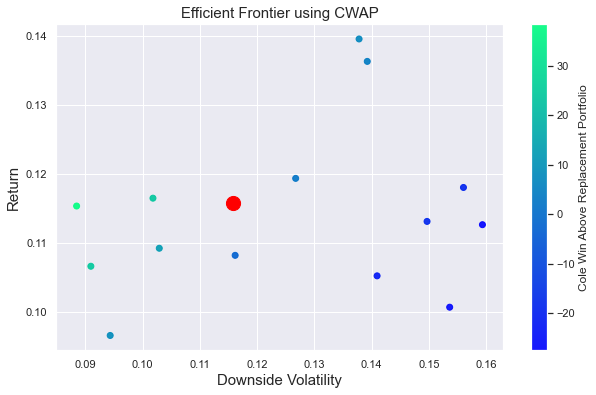

In [21]:
vol_arr=new_risk_ret_df.loc['Vol',new_risk_ret_df.columns[1:]]
ret_arr=new_risk_ret_df.loc['Return',new_risk_ret_df.columns[1:]]
sharpe_arr=new_risk_ret_df.loc['Sharpe',new_risk_ret_df.columns[1:]]
cwarp_arr=risk_ret_df.loc['CWARP',:]
#labels_arr=new_risk_ret_df.columns
max_sr_vol=new_risk_ret_df.loc['Vol',replacement_port_name]
max_sr_ret=new_risk_ret_df.loc['Vol',replacement_port_name]

plt.figure(figsize=(10,6))
plt.scatter(vol_arr, ret_arr, c=cwarp_arr, cmap='winter',label=new_risk_ret_df.columns,alpha=.9)
plt.colorbar(label='Cole Win Above Replacement Portfolio')
plt.title('Efficient Frontier using CWAP', fontsize=15)
plt.xlabel('Downside Volatility',fontsize=15)
plt.ylabel('Return',fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=200) # red dot

plt.show()

Text(0.5, 1.0, 'Efficient Frontier with CWARP')

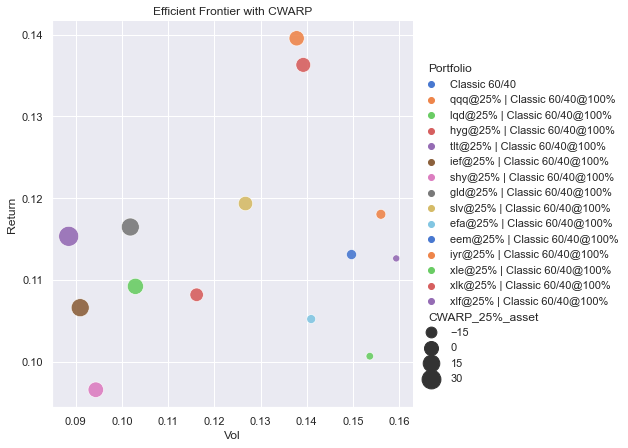

In [12]:
import seaborn as sns
sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(125,10)})

#Load Data
adjust_new_risk = new_risk_ret_df.transpose()
adjust_new_risk['Portfolio']=adjust_new_risk.index

#Plot Seaborn
ax=sns.relplot(x="Vol", y="Return", hue="Portfolio", size="CWARP_25%_asset",
            sizes=(50, 400), alpha=.9, palette="muted",
            height=6, data=adjust_new_risk)
plt.title('Efficient Frontier with CWARP')